In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
from scipy.stats import chi2_contingency
from fuzzywuzzy import process
from rapidfuzz import process, fuzz
import re

/Users/caiocastro/Padrao/GitHub/PJ_Interno/myenv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv('bases/PAC_cleaned.csv')

In [3]:
labels = ['1-50', '51-200', '201-500', '501-1000', '1001-5000', '5001-10000', '10001+']


def exploratory_report(df, target_column, target_value, explained_column):

    list_of_x = []
    list_of_y_abs = []
    list_of_y_proportion = []
   
    new_df = df[[target_column, explained_column]].copy()
        
    # Store the new DataFrame in a dictionary with a dynamic name
    df_total = f'{df}{explained_column}'
    data_frames_dict = {df_total: new_df}

    # Calculate the mean proportion of the target value
    total_count = data_frames_dict[df_total].shape[0]

    target_count = data_frames_dict[df_total][data_frames_dict[df_total][target_column] == target_value].shape[0]

    mean_proportion = target_count / total_count * 100


    print(data_frames_dict[df_total].shape)
    data_frames_dict[df_total].head()

    for value in data_frames_dict[df_total][explained_column].unique():
        
        new_df = data_frames_dict[df_total][data_frames_dict[df_total][explained_column] == value]
        data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'] = new_df


    print('Total:', data_frames_dict[df_total].shape[0])

    for value in data_frames_dict[df_total][explained_column].unique():

        print(f"{value}: {data_frames_dict[df_total][data_frames_dict[df_total][explained_column] == value].shape[0]}")

    for value in data_frames_dict[df_total][explained_column].unique():

        new_df = data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'][data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'][target_column] == target_value]
        data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}'] = new_df

    for value in data_frames_dict[df_total][explained_column].unique():
        
        print(f"{value}  {target_value}: {data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}'].shape[0]}")
        print(f"{value}  Total%: {data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'].shape[0]}")
        print(f'Percentualmente: {100 * data_frames_dict[f"{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}"].shape[0] / data_frames_dict[f"{data_frames_dict[df_total]}_vs_{value}"].shape[0]:.2f}%', end='\n\n')

        list_of_x.append(f'{value} vs {target_value}')
        list_of_y_abs.append(data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}'].shape[0])
        list_of_y_proportion.append(round(100 * data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}'].shape[0] / data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'].shape[0], 2))



    if explained_column != "Mês" and explained_column != "Dia da Semana" and explained_column != "Setor" and explained_column !="Raio" and explained_column != "HorasCorte" and explained_column != "employee_category":
        # Zip the lists and sort based on list_of_y_abs
        sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: x[0], reverse=False)

        # Unzip the sorted data
        sorted_x, sorted_y_abs, sorted_y_proportion = zip(*sorted_data)

        sorted_x = tuple(x.split(' vs ')[0] for x in sorted_x)

        mean_abs = np.mean(sorted_y_abs)
        
        # mean_proportion = np.mean(sorted_y_proportion)

        custom_palette = select_colors(len(sorted_x))

        plt.figure(figsize=(10, 5))

        # Create bar plot for absolute values with sorted data
        sns.barplot(x=sorted_x, y=sorted_y_abs, hue=sorted_x, palette=custom_palette)
        plt.axhline(mean_abs, color='red', linestyle='--')
        # plt.xlabel(f'{explained_column}')
        # plt.ylabel('Aparições')
        # plt.title(f'Problemas de {target_value.lower()} por {explained_column.lower()}')
        plt.xticks(rotation=90)
        # plt.gca().set_yticklabels(['{:.0f}'.format(val) for val in plt.gca().get_yticks()])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.show()

        plt.figure(figsize=(10, 5))

        # Create bar plot for proportions with sorted data
        sns.barplot(x=sorted_x, y=sorted_y_proportion, hue=sorted_x, palette=custom_palette)
        plt.axhline(mean_proportion, color='red', linestyle='--')
        # plt.xlabel(f'{explained_column}')
        # plt.ylabel('Proporção')
        # plt.title(f'Problemas {target_value.lower()} por {explained_column.lower()} (Percentualmente)')
        plt.xticks(rotation=90)
        # plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol
        plt.show()
        
    else:

        if explained_column == "Mês":
            # Sorting by months by zipping
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: Mês.index(x[0].split(' vs ')[0]), reverse=False)
        if explained_column == "Dia da Semana":
            # Sorting by days of the week by zipping
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: DiadaSemana.index(x[0].split(' vs ')[0]), reverse=False)
            
        if explained_column == "Raio":
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: Raio.index(x[0].split(' vs ')[0]), reverse=False)

        if explained_column == "HorasCorte":
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: Horarios.index(x[0].split(' vs ')[0]), reverse=False)

        if explained_column == "employee_category":
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: labels.index(x[0].split(' vs ')[0]), reverse=False)
        # Unzip the sorted data
        sorted_x, sorted_y_abs, sorted_y_proportion = zip(*sorted_data)
        
        sorted_x = tuple(x.split(' vs ')[0] for x in sorted_x)
        # Create bar plot for absolute values with sorted data

        mean_abs = np.mean(sorted_y_abs)

        # mean_proportion = np.mean(sorted_y_proportion)


        custom_palette = select_colors(len(sorted_x))

        plt.figure(figsize=(10, 5))

        # Create bar plot for absolute values with sorted data
        sns.barplot(x=sorted_x, y=sorted_y_abs, hue=sorted_x, palette=custom_palette)
        plt.axhline(mean_abs, color='red', linestyle='--')
        # plt.xlabel(f'{explained_column}')
        # plt.ylabel('Aparições')
        # plt.title(f'Problemas de {target_value.lower()} por {explained_column.lower()}')
        plt.xticks(rotation=90)
        # plt.gca().set_yticklabels(['{:.0f}'.format(val) for val in plt.gca().get_yticks()])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.show()

        plt.figure(figsize=(10, 5))

        # Create bar plot for proportions with sorted data
        sns.barplot(x=sorted_x, y=sorted_y_proportion, hue=sorted_x, palette=custom_palette)
        plt.axhline(mean_proportion, color='red', linestyle='--')
        # plt.xlabel(f'{explained_column}')
        # plt.ylabel('Proporção')
        # plt.title(f'Problemas {target_value.lower()} por {explained_column.lower()} (Percentualmente)')
        plt.xticks(rotation=90)
        # plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol
        plt.show()


In [4]:
bluey = [
    '#001834',
    '#002147',
    '#002a5b',
    '#00336f',
    '#003c82',
    '#004596',
    '#004ea9',
    '#0057bd',
    '#0060d1',
    '#0069e4',
    '#0072f8','#0D7CFF', '#2087FF', '#3492FF', '#479CFF', '#5BA7FF', '#6FB1FF', '#82BCFF', '#96C6FF', '#A9D1FF', '#BDDCFF', '#D1E6FF', '#E4F1FF', '#F8FBFF']


orangey = [
    "#77410E",
    "#8E4E11",
    "#A55A13",
    "#BD6715",
    "#D47317",
    "#E7801E",
    "#EA8D34",
    "#ED9A4B",
    "#F0A762",
    "#F2B479"
]

orangey_reversed = [
    "#F2B479",   
    "#E7801E",
]


bluey_short = [
    '#A9D1FF',
    '#D1E6FF'
]
# Neutral point
neutral = ['#FFFFFF']

# Combined diverging palette
diverging_palette = bluey_short + orangey_reversed    

def select_colors(num_columns):
    if num_columns >= len(bluey):
        return bluey
    
    step = len(bluey) // num_columns
    selected_colors = bluey[:num_columns * step:step]
    return selected_colors

In [5]:
# Write a regex expression to capture the date bewteen the parenthesis in "Semana"


In [6]:
# Convert the "Semana" column to datetime

df['Semana'] = pd.to_datetime(df['Semana'])

In [7]:
# Only keep the Analytics "Portfólio" rows

df = df[df['Portfólio'] == 'Gestão por Processos']



In [8]:
df

,Semana,Empresa,Setor do LinkedIn,Número de Funcionários,Nome,Cargo,Email,Prospecção,STATUS,Hunter,Portfólio,Valor,ITIP
271,2023-01-09,Orgânicos in Box,Food & Beverages,33,Filipe Aguiar,Founder/Co-founder,filipe@organicosinbox.com.br,E-mail,Não Respondeu,isabella.vieira,Gestão por Processos,NaN,NaN
272,2023-01-09,Orgânicos in Box,Food & Beverages,33,Aline Santolia,Founder/Co-founder,aline@organicosinbox.com.br,E-mail,Não Respondeu,isabella.vieira,Gestão por Processos,NaN,NaN
273,2023-01-09,Orgânicos in Box,Food & Beverages,33,Afonso Vianna Junior,CTO,afonso@organicosinbox.com.br,E-mail,Não Respondeu,isabella.vieira,Gestão por Processos,NaN,NaN
274,2023-01-09,Orgânicos in Box,Food & Beverages,33,Carla Nascimento,COO,carla@organicosinbox.com.br,E-mail,Não Respondeu,isabella.vieira,Gestão por Processos,NaN,NaN
275,2023-01-09,BeGreen,Food & Beverages,99,Caroline Ucella,Head,NaN,LinkedIn,Contato Respondido,isabella.vieira,Gestão por Processos,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42315,2024-06-10,Rosewood São Paulo,Outros,300,Cibeli Marques,Diretor Comercial,cibeli.marques@rosewoodhotels.com,E-mail,Não Respondeu,vitor.iwasaki,Gestão por Processos,NaN,NaN
42316,2024-06-10,Rosewood São Paulo,Outros,300,Juliana Riccio,Gerente,juliana.riccio@rosewoodhotels.com,E-mail,Não Respondeu,vitor.iwasaki,Gestão por Processos,NaN,NaN
42317,2024-06-10,Rosewood São Paulo,Outros,300,Carol Cerejo,Outros,ccerejo@cidadematarazzo.com.br,E-mail,Não Respondeu,vitor.iwasaki,Gestão por Processos,NaN,NaN
42318,2024-06-10,Rosewood São Paulo,Outros,300,Caio Sampaio,Outros,caio.sampaio@rosewoodhotels.com,E-mail,Não Respondeu,vitor.iwasaki,Gestão por Processos,NaN,NaN


<Axes: xlabel='Semana'>

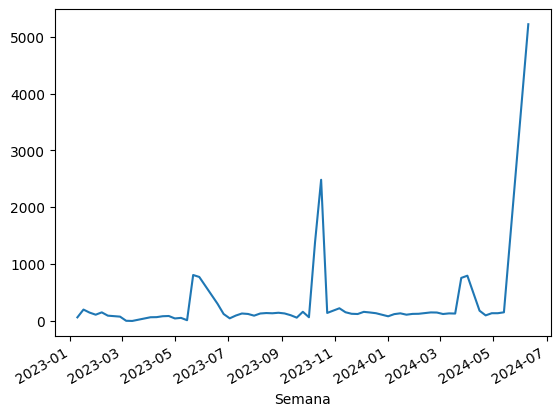

In [9]:
# Plot a time series for the ammount of rows per week

df['Semana'].value_counts().sort_index().plot()

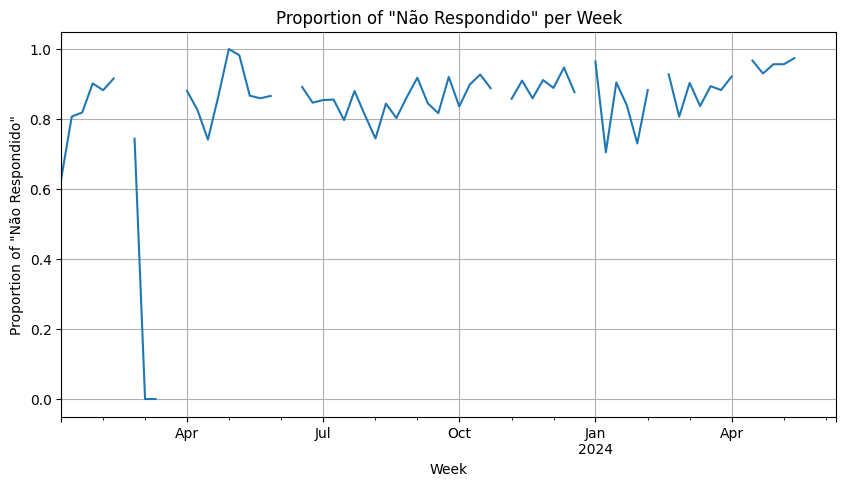

In [10]:
df['Não Respondido'] = df['STATUS'] == 'Não Respondeu'

# Group by week and calculate the proportion of "Não Respondido"
weekly_proportion = df.resample('W-Mon', on='Semana')['Não Respondido'].mean()

# Plotting
plt.figure(figsize=(10, 5))
weekly_proportion.plot( linestyle='-')
plt.title('Proportion of "Não Respondido" per Week')
plt.xlabel('Week')
plt.ylabel('Proportion of "Não Respondido"')
plt.grid(True)
plt.show()

In [11]:
# Count the frequency of the STATUS column

df['STATUS'].value_counts()


STATUS
Não Respondeu          17001
Reunião Marcada          729
Não se Interessou        440
Contato Respondido       407
Contato Encaminhado      238
Projeto                   29
Lead                      16
Contato encaminhado        1
E-mail                     1
Name: count, dtype: int64

In [12]:
#dropna of the first 6 columns

df = df.dropna(subset=df.columns[:6])

In [13]:
# Clean the values of Setor do Linkedin column

df['Setor do LinkedIn'] = df['Setor do LinkedIn'].str.lower().str.strip()

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/1406790230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Setor do LinkedIn'] = df['Setor do LinkedIn'].str.lower().str.strip()


In [14]:
def process_numero_de_funcionarios(value):
    try:
        # Replace different dashes with a standard dash
        value = re.sub(r'–|—', '-', value)
        # Handle ranges
        if '-' in value:
            min_val, max_val = map(int, re.split(r'\s*-\s*', value))
            return (min_val + max_val) / 2
        else:
            return int(value)
    except ValueError:
        # Handle invalid entries
        return None

# Apply the function to the 'Número de Funcionários' column
df['Número de Funcionários'] = df['Número de Funcionários'].apply(process_numero_de_funcionarios)

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/2024980564.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Número de Funcionários'] = df['Número de Funcionários'].apply(process_numero_de_funcionarios)


In [15]:
# Create a df with only the most frequent "Setor do LinkedIn" values

thresholds = [0, 50, 200, 500, 1000, 5000, 10000, float('inf')]
labels = ['1-50', '51-200', '201-500', '501-1000', '1001-5000', '5001-10000', '10001+']

status_encoding = {'Não Respondeu' : 0 , "Não se Interessou" :  0,  "Contato Respondido" : 1, "Contato Encaminhado" : 1,  "Reunião Marcada" : 2, "Lead": 3, "Projeto" : 3}

df['STATUS_encoded'] = df['STATUS'].map(status_encoding)

df.dropna(subset=['STATUS_encoded'], inplace=True)

df.dropna(subset=['Número de Funcionários', 'Empresa'], inplace=True)

idx = df.groupby('Empresa')['STATUS_encoded'].idxmax()


df_companies = df.loc[idx]

df_companies


/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/2450860264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['STATUS_encoded'] = df['STATUS'].map(status_encoding)
/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/2450860264.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['STATUS_encoded'], inplace=True)
/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/2450860264.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

,Semana,Empresa,Setor do LinkedIn,Número de Funcionários,Nome,Cargo,Email,Prospecção,STATUS,Hunter,Portfólio,Valor,ITIP,Não Respondido,STATUS_encoded
12642,2023-08-14,2TM,financial services,293.0,Vitor Delduque,Founder/Co-founder,vitor.delduque@2tmgroup.com,LinkedIn,Lead,clara.milagres,Gestão por Processos,NaN,NaN,False,3.0
18391,2023-10-09,2W Ecobank,energy & environment,310.0,Taciana Franco,Head,taciana.franco@2wecobank.com.br,E-mail,Contato Respondido,mateus.dessimoni,Gestão por Processos,NaN,NaN,False,1.0
23455,2023-12-04,3R Petroleum,energy & environment,710.0,Mauro Sant'anna,Gerente de Operações,mauro.santanna@3rpetroleum.com.br,E-mail,Reunião Marcada,vinicius.giro,Gestão por Processos,NaN,NaN,False,2.0
11992,2023-07-31,3S Corp,outros,180.0,Lucas Schommer,Diretor,lucas.vogt@3scorporate.com,LinkedIn,Contato Encaminhado,clara.milagres,Gestão por Processos,NaN,NaN,False,1.0
30712,2024-04-22,4BIO Medicamentos Especiais,health & fitness,380.0,Emerson Viviani,Diretor,emerson@4bio.com.br,E-mail,Não Respondeu,joao.botelho,Gestão por Processos,NaN,NaN,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17448,2023-10-09,will bank,financial services,1300.0,Ricardo Saad,CFO,ricardo.saad@willbank.com.br,E-mail,Contato Respondido,bruno.tonso,Gestão por Processos,NaN,NaN,False,1.0
7752,2023-05-22,Ágora Investimentos,financial services,530.0,Dalton Gardimam,Outro C-Level,dalton.gardimam@agorainvestimentos.com.br,E-mail,Não Respondeu,daniel.alves,Gestão por Processos,NaN,NaN,True,0.0
5901,2023-05-15,Água de Cheiro,consumer goods & services,350.0,Gustavo Monteiro,Outro C-Level,NaN,LinkedIn,Não Respondeu,nathalia.pimentel,Gestão por Processos,NaN,NaN,True,0.0
411,2023-01-16,Órigo Energia,energy & environment,528.0,Rodolfo Molinari Filho,Outro C-Level,rodolfo.molinari@origoenergia.com.br,LinkedIn,Contato Encaminhado,isabella.vieira,Gestão por Processos,NaN,NaN,False,1.0


(1316, 2)
Total: 1316
financial services: 175
energy & environment: 117
outros: 41
health & fitness: 121
information technology & services: 226
logistics & supply chain: 156
industrial: 48
agronegócio: 86
retail: 38
telecommunications: 43
insurance: 86
chemicals: 41
education: 18
food & beverages: 92
computer software & internet: 28
financial services  Reunião Marcada: 62
financial services  Total%: 175
Percentualmente: 35.43%

energy & environment  Reunião Marcada: 49
energy & environment  Total%: 117
Percentualmente: 41.88%

outros  Reunião Marcada: 15
outros  Total%: 41
Percentualmente: 36.59%

health & fitness  Reunião Marcada: 37
health & fitness  Total%: 121
Percentualmente: 30.58%

information technology & services  Reunião Marcada: 70
information technology & services  Total%: 226
Percentualmente: 30.97%

logistics & supply chain  Reunião Marcada: 59
logistics & supply chain  Total%: 156
Percentualmente: 37.82%

industrial  Reunião Marcada: 13
industrial  Total%: 48
Percentualm

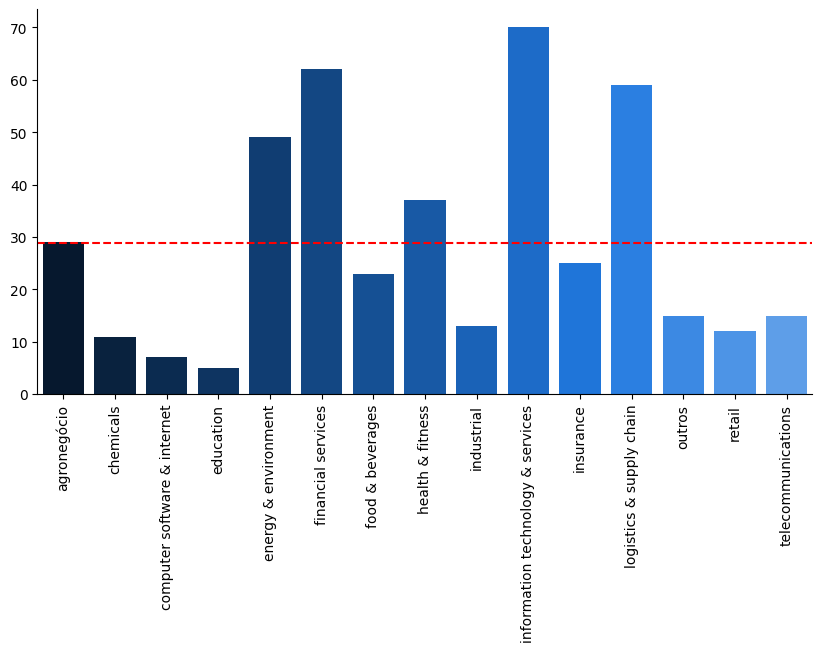

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


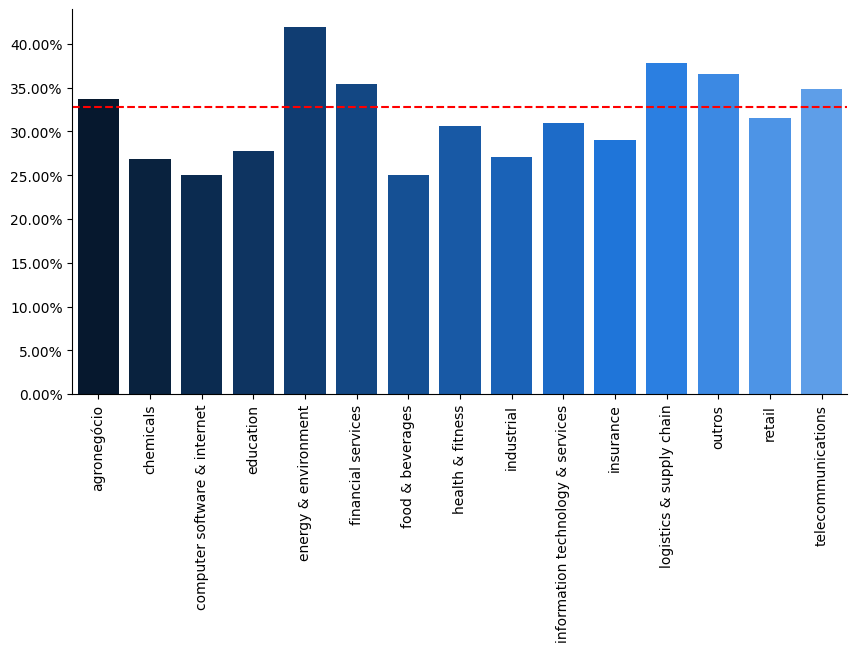

In [16]:
# Create a new column 'employee_category' based on the thresholds


df_companies['employee_category'] = pd.cut(df_companies['Número de Funcionários'], bins=thresholds, labels=labels, right=False)

df_companies.dropna(subset=['employee_category'], inplace=True)

dfmainsectors = df_companies[df_companies['Setor do LinkedIn'].isin(df_companies['Setor do LinkedIn'].value_counts().head(15).index)]

exploratory_report(dfmainsectors, 'STATUS', 'Reunião Marcada', 'Setor do LinkedIn')

(1316, 2)
Total: 1316
financial services: 175
energy & environment: 117
outros: 41
health & fitness: 121
information technology & services: 226
logistics & supply chain: 156
industrial: 48
agronegócio: 86
retail: 38
telecommunications: 43
insurance: 86
chemicals: 41
education: 18
food & beverages: 92
computer software & internet: 28
financial services  Projeto: 1
financial services  Total%: 175
Percentualmente: 0.57%

energy & environment  Projeto: 2
energy & environment  Total%: 117
Percentualmente: 1.71%

outros  Projeto: 0
outros  Total%: 41
Percentualmente: 0.00%

health & fitness  Projeto: 1
health & fitness  Total%: 121
Percentualmente: 0.83%

information technology & services  Projeto: 4
information technology & services  Total%: 226
Percentualmente: 1.77%

logistics & supply chain  Projeto: 5
logistics & supply chain  Total%: 156
Percentualmente: 3.21%

industrial  Projeto: 0
industrial  Total%: 48
Percentualmente: 0.00%

agronegócio  Projeto: 3
agronegócio  Total%: 86
Percentu

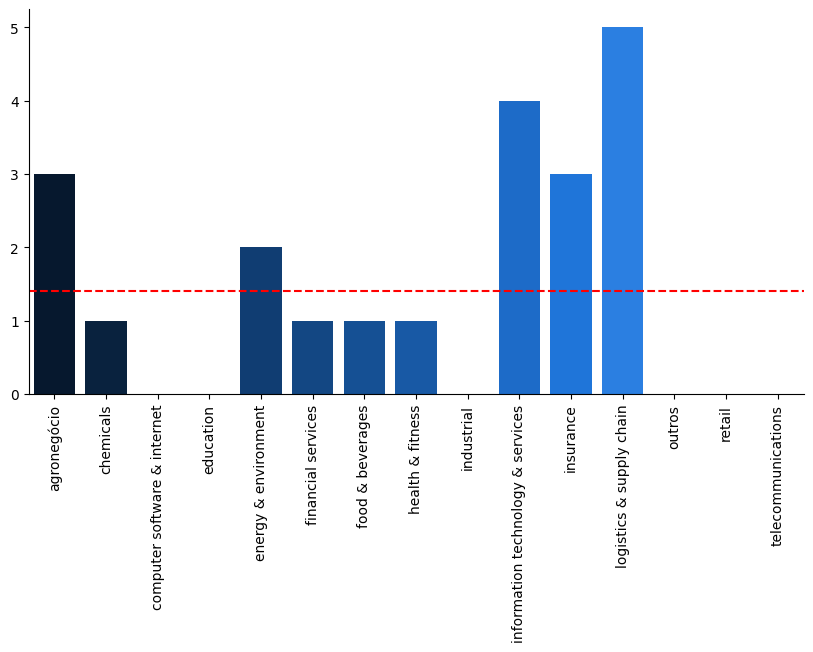

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


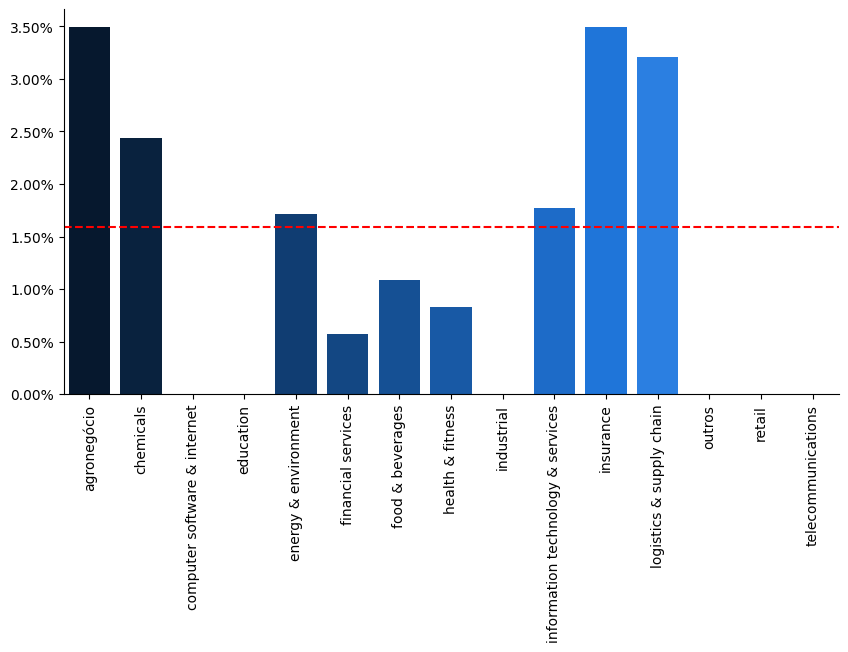

In [17]:
exploratory_report(dfmainsectors, 'STATUS', 'Projeto', 'Setor do LinkedIn')

In [18]:
# Count the frequency of "Cargo" column

df['Cargo'].value_counts()

Cargo
Diretor                   3289
Gerente                   3138
Head                      2336
Outros                    2269
CEO                        870
                          ... 
Diretor administrativo       1
Executive HR Manager         1
Head Of Data                 1
Gerente De Facillities       1
Cfo                          1
Name: count, Length: 109, dtype: int64

In [19]:
import pandas as pd
from rapidfuzz import process

# Define the number of most common values to consider
num_common = 10  # Adjust this number as needed
similarity_threshold = 80  # Adjust this threshold as needed

# Get the most common values in 'Cargo'
common_cargos = df['Cargo'].value_counts().index[:num_common]

# Function to apply fuzzy matching with a threshold
def fuzzy_match(cargo, choices, threshold):
    match = process.extractOne(cargo, choices, score_cutoff=threshold)
    if match:
        return match[0]  # match[0] contains the best match string
    else:
        return "others"

# Apply fuzzy matching using the most common values and classify as "others" if no close match
df['Cargo'] = df['Cargo'].apply(lambda x: fuzzy_match(x, common_cargos, similarity_threshold))

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/1619003796.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cargo'] = df['Cargo'].apply(lambda x: fuzzy_match(x, common_cargos, similarity_threshold))


(18276, 2)
Total: 18276
others: 1142
Head: 3280
Diretor: 4145
CEO: 870
CFO: 697
Gerente: 3670
Diretor de Operações: 681
Diretor Comercial: 529
Outro C-Level: 432
Outros: 2269
Presidente/Vice Presidente: 561
others  Reunião Marcada: 44
others  Total%: 1142
Percentualmente: 3.85%

Head  Reunião Marcada: 116
Head  Total%: 3280
Percentualmente: 3.54%

Diretor  Reunião Marcada: 148
Diretor  Total%: 4145
Percentualmente: 3.57%

CEO  Reunião Marcada: 28
CEO  Total%: 870
Percentualmente: 3.22%

CFO  Reunião Marcada: 26
CFO  Total%: 697
Percentualmente: 3.73%

Gerente  Reunião Marcada: 117
Gerente  Total%: 3670
Percentualmente: 3.19%

Diretor de Operações  Reunião Marcada: 47
Diretor de Operações  Total%: 681
Percentualmente: 6.90%

Diretor Comercial  Reunião Marcada: 15
Diretor Comercial  Total%: 529
Percentualmente: 2.84%

Outro C-Level  Reunião Marcada: 22
Outro C-Level  Total%: 432
Percentualmente: 5.09%

Outros  Reunião Marcada: 94
Outros  Total%: 2269
Percentualmente: 4.14%

Presidente/Vi

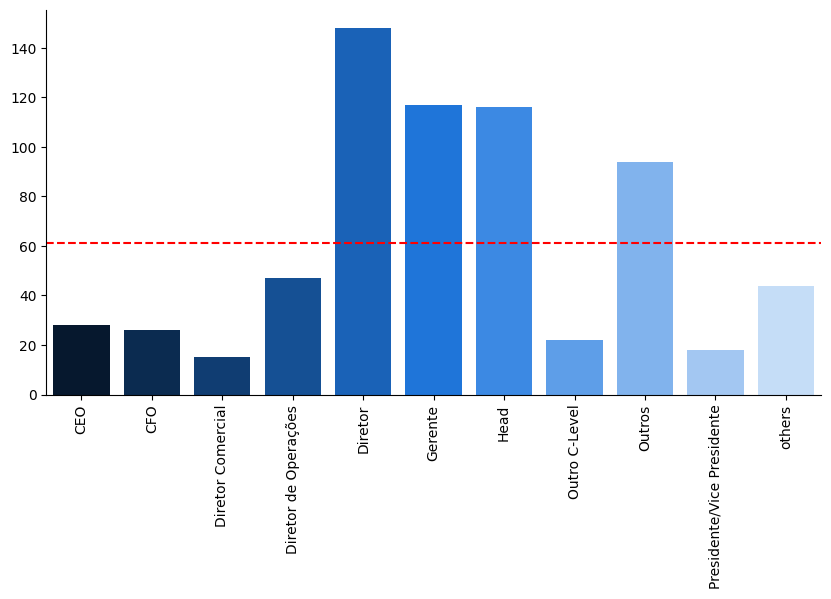

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


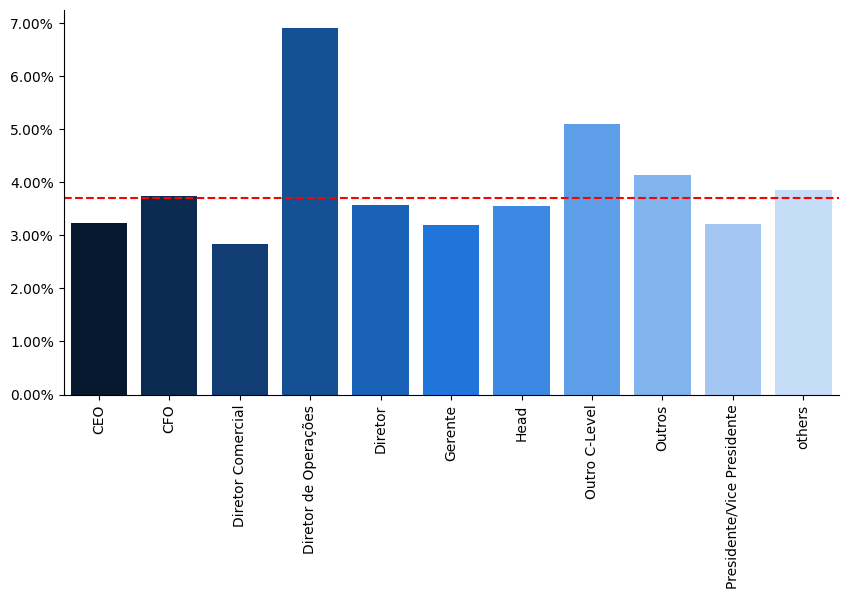

In [20]:
# Create a df with only the most frequent "Cargo" values

dfmaincargo = df[df['Cargo'].isin(df['Cargo'].value_counts().head(15).index)]

exploratory_report(dfmaincargo, 'STATUS', 'Reunião Marcada', 'Cargo')

(18276, 2)
Total: 18276
others: 1142
Head: 3280
Diretor: 4145
CEO: 870
CFO: 697
Gerente: 3670
Diretor de Operações: 681
Diretor Comercial: 529
Outro C-Level: 432
Outros: 2269
Presidente/Vice Presidente: 561
others  Projeto: 3
others  Total%: 1142
Percentualmente: 0.26%

Head  Projeto: 7
Head  Total%: 3280
Percentualmente: 0.21%

Diretor  Projeto: 4
Diretor  Total%: 4145
Percentualmente: 0.10%

CEO  Projeto: 1
CEO  Total%: 870
Percentualmente: 0.11%

CFO  Projeto: 3
CFO  Total%: 697
Percentualmente: 0.43%

Gerente  Projeto: 2
Gerente  Total%: 3670
Percentualmente: 0.05%

Diretor de Operações  Projeto: 2
Diretor de Operações  Total%: 681
Percentualmente: 0.29%

Diretor Comercial  Projeto: 0
Diretor Comercial  Total%: 529
Percentualmente: 0.00%

Outro C-Level  Projeto: 0
Outro C-Level  Total%: 432
Percentualmente: 0.00%

Outros  Projeto: 0
Outros  Total%: 2269
Percentualmente: 0.00%

Presidente/Vice Presidente  Projeto: 0
Presidente/Vice Presidente  Total%: 561
Percentualmente: 0.00%



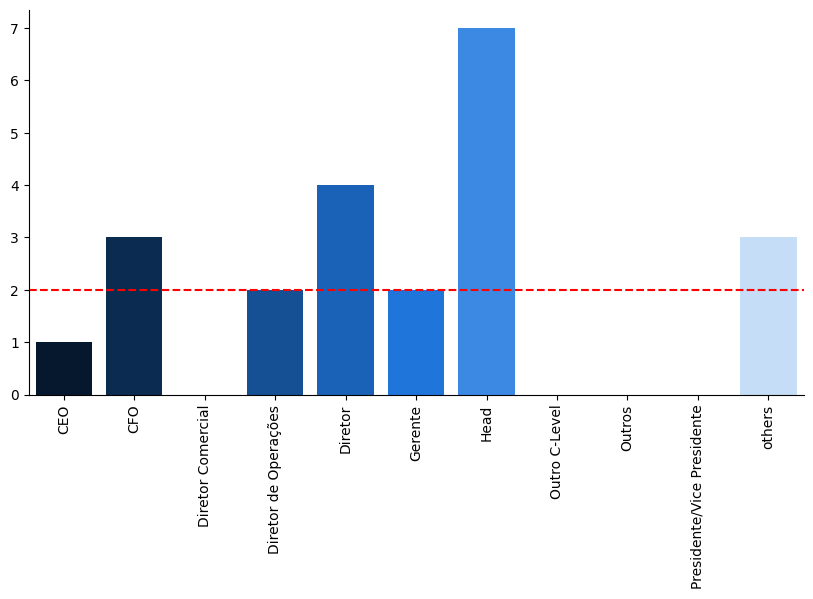

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


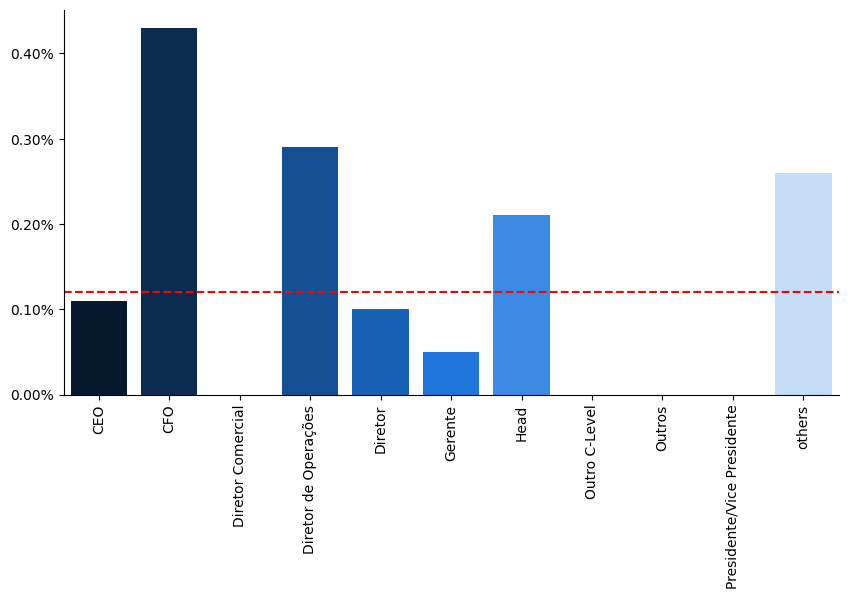

In [21]:
exploratory_report(dfmaincargo, 'STATUS', 'Projeto', 'Cargo')

(18276, 2)
Total: 18276
E-mail: 17561
LinkedIn: 715
E-mail  Reunião Marcada: 570
E-mail  Total%: 17561
Percentualmente: 3.25%

LinkedIn  Reunião Marcada: 105
LinkedIn  Total%: 715
Percentualmente: 14.69%



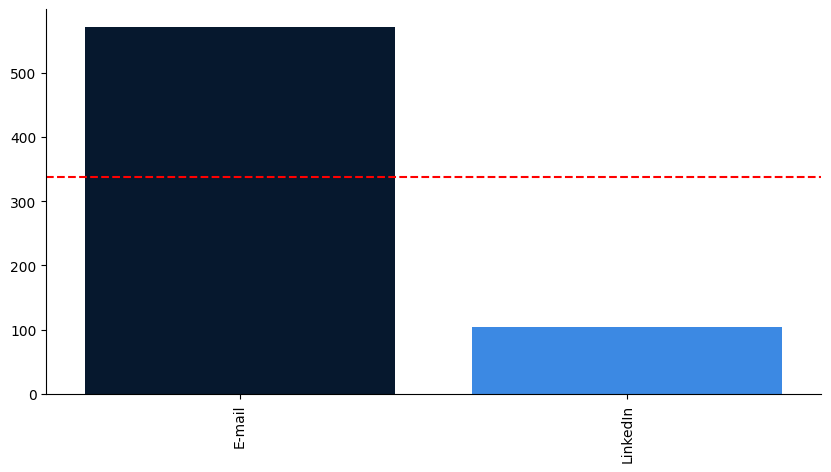

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


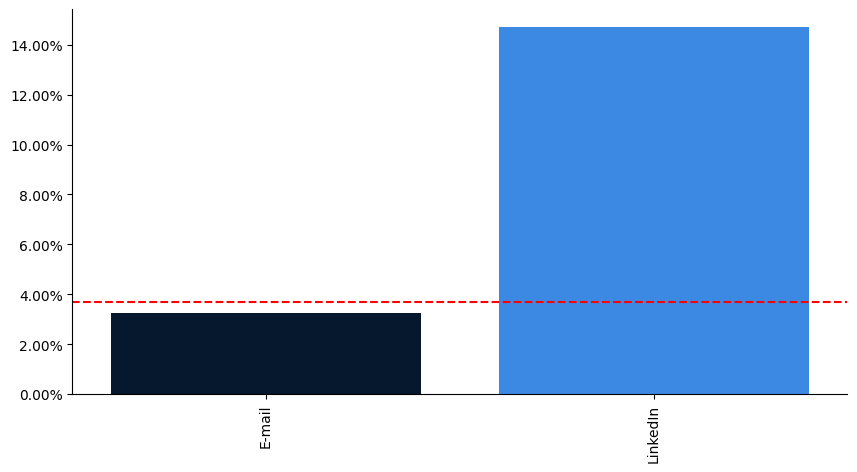

In [22]:
exploratory_report(df, 'STATUS', 'Reunião Marcada', 'Prospecção')

(18276, 2)
Total: 18276
E-mail: 17561
LinkedIn: 715
E-mail  Projeto: 18
E-mail  Total%: 17561
Percentualmente: 0.10%

LinkedIn  Projeto: 4
LinkedIn  Total%: 715
Percentualmente: 0.56%



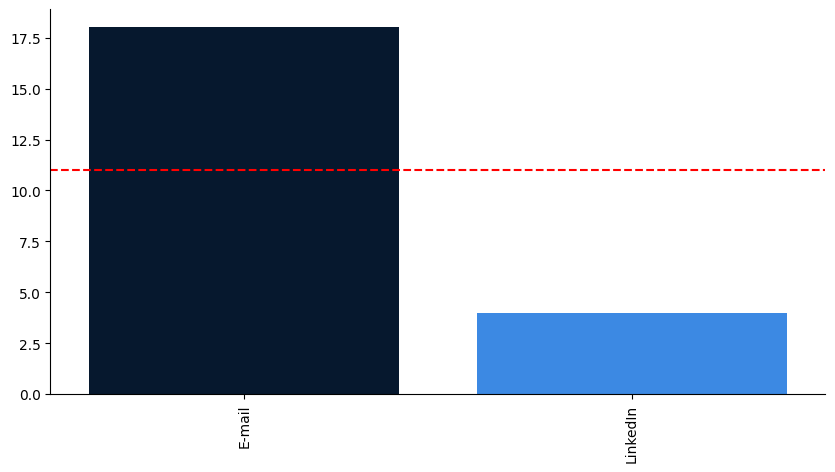

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


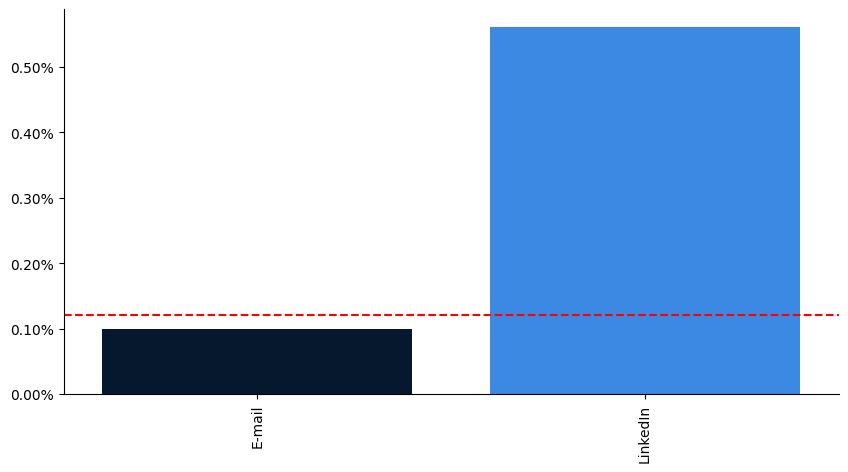

In [23]:
exploratory_report(df, 'STATUS', 'Projeto', 'Prospecção')

(1369, 2)
Total: 1369
201-500: 246
501-1000: 293
51-200: 119
1001-5000: 421
5001-10000: 87
10001+: 160
1-50: 43
201-500  Reunião Marcada: 80
201-500  Total%: 246
Percentualmente: 32.52%

501-1000  Reunião Marcada: 86
501-1000  Total%: 293
Percentualmente: 29.35%

51-200  Reunião Marcada: 38
51-200  Total%: 119
Percentualmente: 31.93%

1001-5000  Reunião Marcada: 133
1001-5000  Total%: 421
Percentualmente: 31.59%

5001-10000  Reunião Marcada: 31
5001-10000  Total%: 87
Percentualmente: 35.63%

10001+  Reunião Marcada: 73
10001+  Total%: 160
Percentualmente: 45.62%

1-50  Reunião Marcada: 10
1-50  Total%: 43
Percentualmente: 23.26%



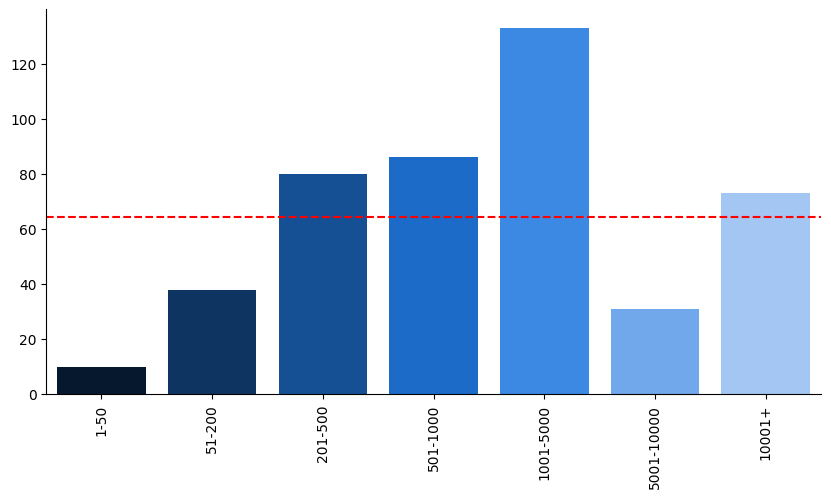

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/815668103.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


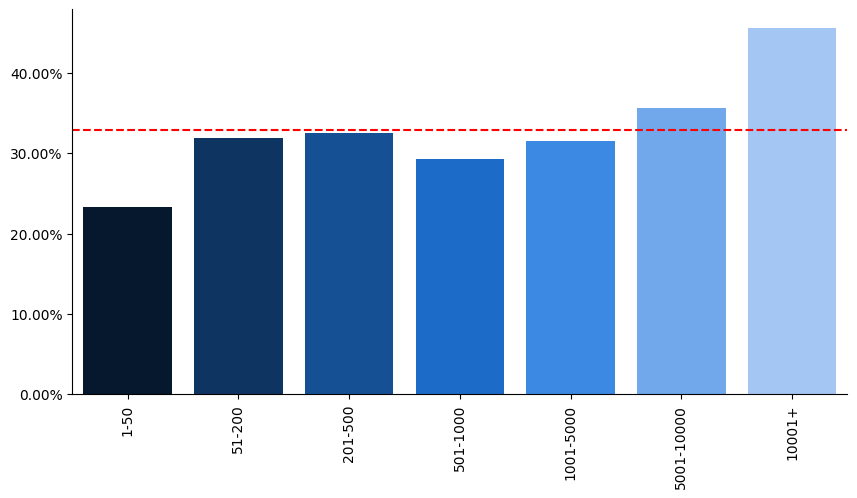

In [24]:
exploratory_report(df_companies, 'STATUS', 'Reunião Marcada', 'employee_category')

(1369, 2)
Total: 1369
201-500: 246
501-1000: 293
51-200: 119
1001-5000: 421
5001-10000: 87
10001+: 160
1-50: 43
201-500  Projeto: 2
201-500  Total%: 246
Percentualmente: 0.81%

501-1000  Projeto: 4
501-1000  Total%: 293
Percentualmente: 1.37%

51-200  Projeto: 3
51-200  Total%: 119
Percentualmente: 2.52%

1001-5000  Projeto: 9
1001-5000  Total%: 421
Percentualmente: 2.14%

5001-10000  Projeto: 2
5001-10000  Total%: 87
Percentualmente: 2.30%

10001+  Projeto: 1
10001+  Total%: 160
Percentualmente: 0.62%

1-50  Projeto: 1
1-50  Total%: 43
Percentualmente: 2.33%



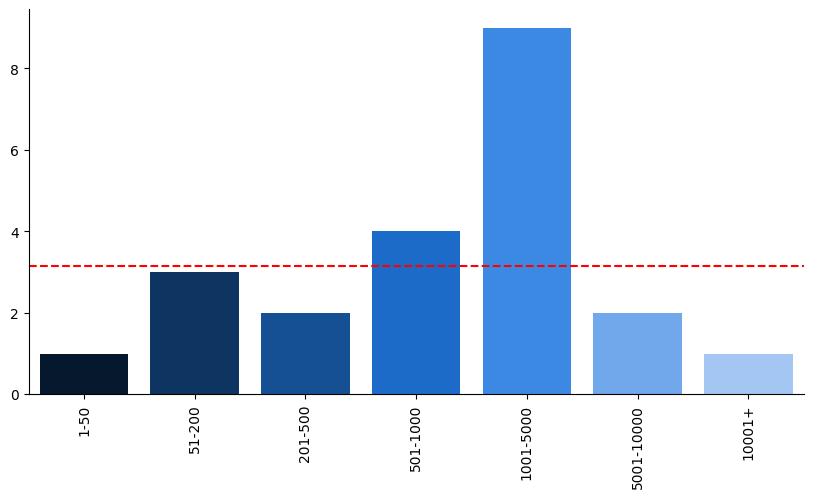

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5146/815668103.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


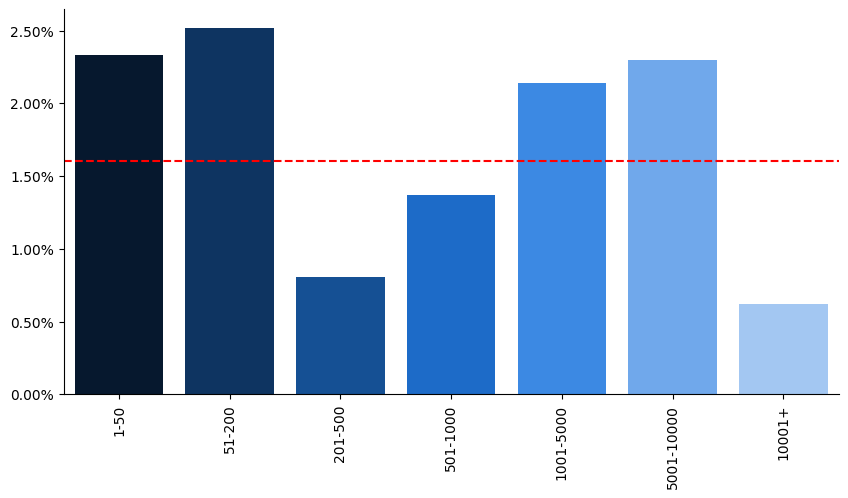

In [25]:
exploratory_report(df_companies, 'STATUS', 'Projeto', 'employee_category')